In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

In [13]:
def init_distrib_consensus_data(consensus_data, experiment, N, R, confidence, cluster_data):
    if not ((consensus_data['N'] == N) 
            & (round(consensus_data['eps1'],2) == round(R[0],2))
            & (round(consensus_data['eps2'],2) == round(R[1],2))
            ).any():
        consensus_data.at[experiment, "N"] = N
        consensus_data.at[experiment, "confidence"] = confidence.__name__

        consensus_data.at[experiment, "eps1"] = round(R[0],2)
        consensus_data.at[experiment, "eps2"] = round(R[1],2)

        consensus_data.at[experiment, "consensus_x"] = 0
        consensus_data.at[experiment, "consensus_y"] = 0
        consensus_data.at[experiment, "consensus_probabity"] =0
        consensus_data.at[experiment, "simulation_time"] =0
        consensus_data.at[experiment, "simulation_count"] = 0
        # consensus_data.at[experiment, "cluster_data"] = cluster_data


def update_distrib_consensus_data(consensus_data, experiment, res_arr_fast):
    consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    consensus_data.at[experiment, "consensus_probabity"] +=1
    consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    

dtypes = {
    'N': np.int64,
    'confidence': str,
    'eps1': np.float64,
    'eps2': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64,
    'cluster_data' : str
}
# consensus_data = pd.DataFrame(columns=["N","confidence","eps1","eps2", "consensus_x", "consensus_y","consensus_probabity", "simulation_time", "cluster_data"], dtype=object)
# consensus_data

,N,confidence,eps1,eps2,consensus_x,consensus_y,consensus_probabity,simulation_time,cluster_data


In [ ]:
consensus_data = pd.read_csv('expon_distib_consensus_data.csv', sep=";", dtype=dtypes)
consensus_data

In [19]:
consensus_data.to_csv('rectangle_distib_consensus_data.csv',sep=";", index=False)

In [4]:
experiments = 100

eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n


In [5]:
R_array=[]
for i in np.arange(0.15, .6, 0.05):
    for j in np.arange(0.15, .6, 0.05):
        if i>j:
            continue
        R_array.append((round(i,2), round(j, 2)))
R_array = np.array(R_array)
R_array

array([[0.15, 0.15],
       [0.15, 0.2 ],
       [0.15, 0.25],
       [0.15, 0.3 ],
       [0.15, 0.35],
       [0.15, 0.4 ],
       [0.15, 0.45],
       [0.15, 0.5 ],
       [0.15, 0.55],
       [0.2 , 0.2 ],
       [0.2 , 0.25],
       [0.2 , 0.3 ],
       [0.2 , 0.35],
       [0.2 , 0.4 ],
       [0.2 , 0.45],
       [0.2 , 0.5 ],
       [0.2 , 0.55],
       [0.25, 0.25],
       [0.25, 0.3 ],
       [0.25, 0.35],
       [0.25, 0.4 ],
       [0.25, 0.45],
       [0.25, 0.5 ],
       [0.25, 0.55],
       [0.3 , 0.3 ],
       [0.3 , 0.35],
       [0.3 , 0.4 ],
       [0.3 , 0.45],
       [0.3 , 0.5 ],
       [0.3 , 0.55],
       [0.35, 0.35],
       [0.35, 0.4 ],
       [0.35, 0.45],
       [0.35, 0.5 ],
       [0.35, 0.55],
       [0.4 , 0.4 ],
       [0.4 , 0.45],
       [0.4 , 0.5 ],
       [0.4 , 0.55],
       [0.45, 0.45],
       [0.45, 0.5 ],
       [0.45, 0.55],
       [0.5 , 0.5 ],
       [0.5 , 0.55],
       [0.55, 0.55]])

In [6]:
R_array.shape

(45, 2)

In [9]:
clusters_data = np.zeros(N, dtype=list)
cluster_sizes = np.zeros(N)

In [7]:
func = create_rectangle_conf_func

In [14]:
# experiment = consensus_data.index[-1] +1
experiment=0
simulation_func=HK_2D_sim

for R in R_array:
    confidence = func(*R)
    file_name=f'clusters_data/cluster_data_{confidence.__name__}_{N}_{R}.npy'
    init_distrib_consensus_data(consensus_data, experiment, N, R, confidence, file_name)
    print(f"N:{N} R:{R} func:{simulation_func.__name__}")

    for i in trange(experiments):
        # x0 = my_rv.rvs(size = (N,2))
        x0 = np.random.sample((N,2))

        res_arr_fast, check_fast = simulation_func(x0, confidence, 1e-7, 1000)
        if check_fast:
            cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], confidence)

            # cluster_positions = get_cluster_positions(res_arr_fast[-1, :, :], cluster_of_agent, cluster_sizes)
            # clusters_data[len(cluster_sizes)-1] = np.append(clusters_data[len(cluster_sizes)-1], cluster_positions)
            
            experiment = consensus_data[
                ((consensus_data['N'] == N) 
                & (round(consensus_data['eps1'],2) == round(R[0],2))
                & (round(consensus_data['eps2'],2) == round(R[1],2))
                )
                ].index[0]
            consensus_data.at[experiment, "simulation_count"] +=1
            
            if len(cluster_sizes)==1:
                # we have consensus
                update_distrib_consensus_data(consensus_data, experiment, res_arr_fast)
        else:
            draw_HK_2D_simulation(res_arr_fast, 'plasma')
    experiment = consensus_data.index[-1] +1
    # np.save(file_name, clusters_data)


N:50 R:[0.15 0.15] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.52it/s]


N:50 R:[0.15 0.2 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 144.53it/s]


N:50 R:[0.15 0.25] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 128.43it/s]


N:50 R:[0.15 0.3 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 149.43it/s]


N:50 R:[0.15 0.35] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 148.92it/s]


N:50 R:[0.15 0.4 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 155.21it/s]


N:50 R:[0.15 0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 157.04it/s]


N:50 R:[0.15 0.5 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 131.71it/s]


N:50 R:[0.15 0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 156.92it/s]


N:50 R:[0.2 0.2] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 152.43it/s]


N:50 R:[0.2  0.25] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 149.35it/s]


N:50 R:[0.2 0.3] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 131.40it/s]


N:50 R:[0.2  0.35] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 149.20it/s]


N:50 R:[0.2 0.4] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 146.29it/s]


N:50 R:[0.2  0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 151.47it/s]


N:50 R:[0.2 0.5] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 126.11it/s]


N:50 R:[0.2  0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 106.78it/s]


N:50 R:[0.25 0.25] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.71it/s]


N:50 R:[0.25 0.3 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.24it/s]


N:50 R:[0.25 0.35] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.23it/s]


N:50 R:[0.25 0.4 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 156.26it/s]


N:50 R:[0.25 0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 130.47it/s]


N:50 R:[0.25 0.5 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 152.44it/s]


N:50 R:[0.25 0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 142.12it/s]


N:50 R:[0.3 0.3] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 151.10it/s]


N:50 R:[0.3  0.35] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.65it/s]


N:50 R:[0.3 0.4] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 120.43it/s]


N:50 R:[0.3  0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 140.55it/s]


N:50 R:[0.3 0.5] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 147.91it/s]


N:50 R:[0.3  0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 158.92it/s]


N:50 R:[0.35 0.35] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 157.26it/s]


N:50 R:[0.35 0.4 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 151.12it/s]


N:50 R:[0.35 0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 131.86it/s]


N:50 R:[0.35 0.5 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 156.20it/s]


N:50 R:[0.35 0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 159.90it/s]


N:50 R:[0.4 0.4] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 163.54it/s]


N:50 R:[0.4  0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 166.86it/s]


N:50 R:[0.4 0.5] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 137.58it/s]


N:50 R:[0.4  0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 175.80it/s]


N:50 R:[0.45 0.45] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 158.77it/s]


N:50 R:[0.45 0.5 ] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 165.40it/s]


N:50 R:[0.45 0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 155.31it/s]


N:50 R:[0.5 0.5] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 133.45it/s]


N:50 R:[0.5  0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 167.51it/s]


N:50 R:[0.55 0.55] func:HK_2D_sim


100%|██████████| 100/100 [00:00<00:00, 168.51it/s]


In [15]:
consensus_data

,N,confidence,eps1,eps2,consensus_x,consensus_y,consensus_probabity,simulation_time,cluster_data,simulation_count
0,50,rectangle,0.15,0.15,0,0,0,0,NaN,100.0
1,50,rectangle,0.15,0.2,0,0,0,0,NaN,100.0
2,50,rectangle,0.15,0.25,0,0,0,0,NaN,100.0
3,50,rectangle,0.15,0.3,0,0,0,0,NaN,100.0
4,50,rectangle,0.15,0.35,0,0,0,0,NaN,100.0
5,50,rectangle,0.15,0.4,0,0,0,0,NaN,100.0
6,50,rectangle,0.15,0.45,0,0,0,0,NaN,100.0
7,50,rectangle,0.15,0.5,0,0,0,0,NaN,100.0
8,50,rectangle,0.15,0.55,0,0,0,0,NaN,100.0
9,50,rectangle,0.2,0.2,0,0,0,0,NaN,100.0


In [16]:
%matplotlib widget

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_15916\2317396878.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


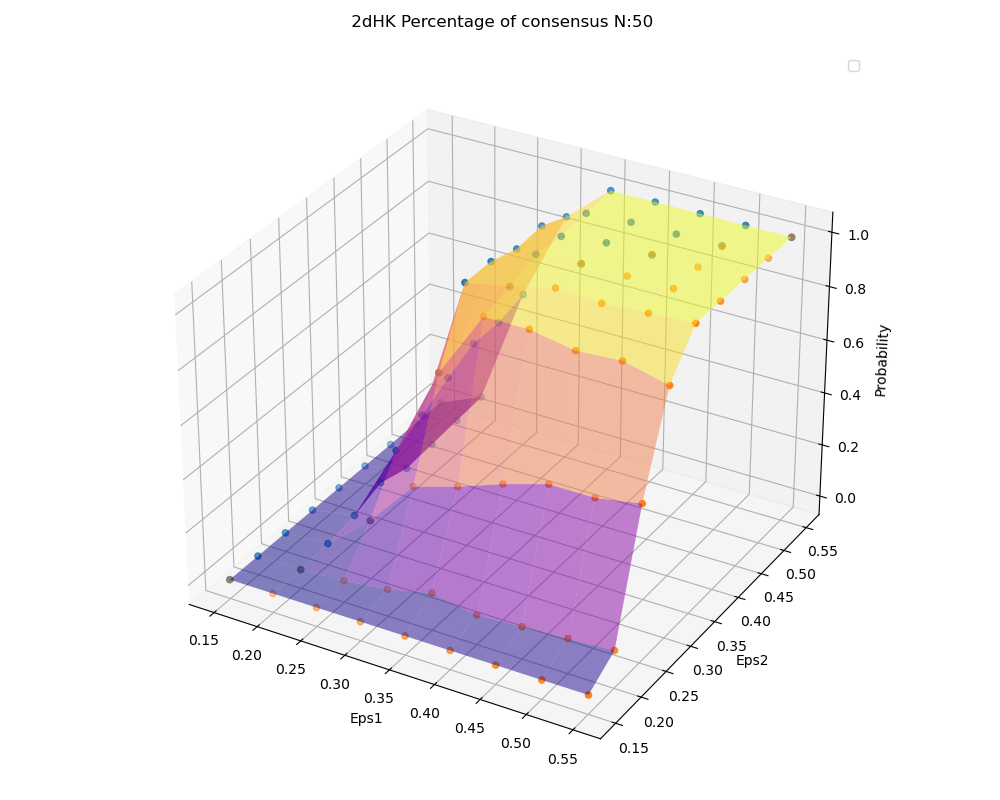

In [18]:
import numpy as np
ax = plt.figure(figsize=(10, 8)).add_subplot(projection='3d')

# Plot lines for each beta value

df = consensus_data.query('N == @N and confidence == "rectangle"')
ax.scatter3D(df['eps1'], df['eps2'], df['consensus_probabity']/df['simulation_count'] )
ax.scatter3D(df['eps2'], df['eps1'], df['consensus_probabity']/df['simulation_count'] )

vals = np.sort(df['eps1'].unique())
n = vals.shape[0]
X = np.zeros((n, n), dtype=float)
Y = np.zeros((n, n), dtype=float)
Z = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n): 
        x = vals[i]
        y = vals[j]
        for k in range(len(df['eps1'])):
            if df['eps1'][k] == x and df['eps2'][k] == y or \
               df['eps1'][k] == y and df['eps2'][k] == x:
                X[i, j] = x
                Y[i, j] = y
                Z[i, j] = df['consensus_probabity'][k]/df['simulation_count'][k]

ax.plot_surface(X, Y, Z, alpha=0.5, cmap='plasma')

# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n')
plt.xlabel('Eps1')
plt.ylabel('Eps2')
ax.set_zlabel('Probability')

plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [81]:
%matplotlib inline

In [97]:
row=df.head(1)
row

,N,confidence,eps1,eps2,consensus_x,consensus_y,consensus_probabity,simulation_time,cluster_data,simulation_count
0,50,rectangle,0.15,0.15,0,0,0,0,clusters_data/cluster_data_rectangle_50_[0.15 ...,10.0


In [99]:
row["cluster_data"][0]

'clusters_data/cluster_data_rectangle_50_[0.15 0.15].npy'

In [108]:
cl_rs

array([array([0.        , 0.57568603, 0.5141891 , 0.43629153, 0.57165206,
              0.51761783, 0.45681542, 0.42533378, 0.44925429, 0.53483365,
              0.50834306, 0.56269968, 0.52021014, 0.46343798, 0.55277527,
              0.55426556, 0.50142452, 0.48861306, 0.55400443, 0.51471067,
              0.39964688, 0.52160319, 0.53860405, 0.38723503, 0.50717188,
              0.44413711, 0.4571155 , 0.48032027, 0.52804873, 0.48236391,
              0.56752625, 0.56259617, 0.53541825, 0.50863863, 0.62980454,
              0.49316961, 0.50125118, 0.49042204, 0.40840726, 0.57113919,
              0.54237444, 0.56713248, 0.51711112, 0.45663965, 0.50224659,
              0.53254664, 0.47393247, 0.51527788, 0.47169983, 0.51380431,
              0.56309686, 0.41166178, 0.48681882, 0.5089728 , 0.44073297,
              0.54437925, 0.60204467, 0.5772783 , 0.45538539, 0.48651422,
              0.54097283, 0.52818112, 0.41806504, 0.42191015, 0.53077325,
              0.41290636, 0.5896465 , 

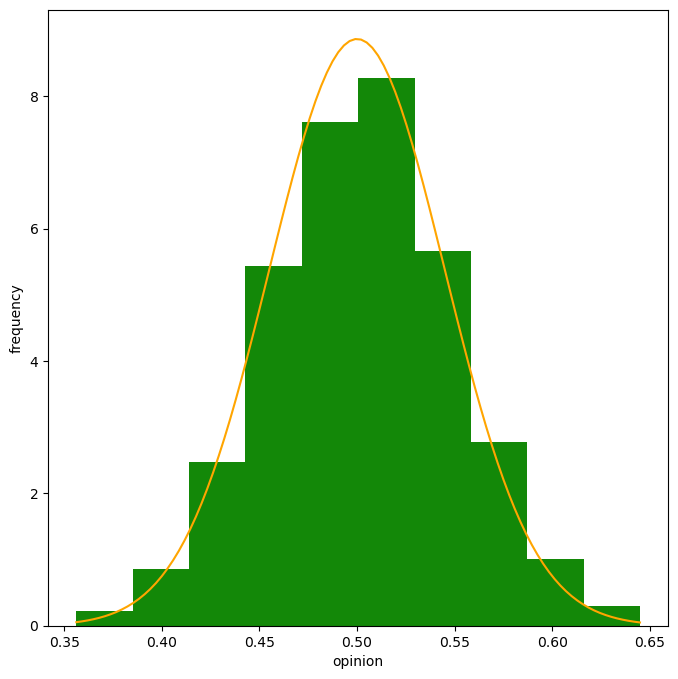

In [104]:
cl_rs  = np.load(row["cluster_data"][0], allow_pickle=True)
fig = plt.figure(facecolor='white', figsize=(8, 8))
hist = plt.hist(np.array(cl_rs[0][1:]), density = True, stacked = True, color = '#138808')
x = np.linspace(hist[1].min(), hist[1].max(), num=100)
plt.title
plt.plot(x, stats.norm.pdf(x,0.5,0.045), color ="orange")
plt.xlabel('opinion')
plt.ylabel('frequency')
plt.show()

In [110]:
clusters_data[0]

array([0.        , 0.57568603, 0.5141891 , ..., 0.5275296 , 0.56107459,
       0.50414076])

Тест

In [3]:
R = 0.125 + 0.000001
R = (R*2, R)
round_nei = create_rectangle_conf_func(*R)

n = 20
S = 1.0
N = n ** 2
init_pos = np.zeros((N, 2), dtype=float)
for i in range(n):
    for j in range(n):
        init_pos[i * n + j] = [i / n * S, j / n * S]
# init_pos[-1] = np.random.rand(2) * S

In [4]:
res_arr, check = HK_2D_sim(init_pos, round_nei, 1e-7, 1000)
assert(check)
cluster_of_agent, cluster_sizes=caln_n_clusters(res_arr[-1, :, :], round_nei)
cluster_positions = get_cluster_positions(res_arr[-1, :, :], cluster_of_agent, cluster_sizes)
cluster_sizes, cluster_positions

(array([120, 160, 120], dtype=int64),
 array([[0.475    , 0.1683149],
        [0.475    , 0.475    ],
        [0.475    , 0.7816851]]))

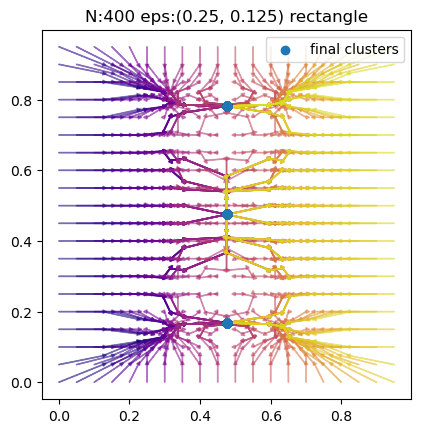

In [18]:
draw_HK_2D_simulation(res_arr,N=N, R=(round(R[0], 3), round(R[1], 3)),text=f'{round_nei.__name__}', cmap='plasma')

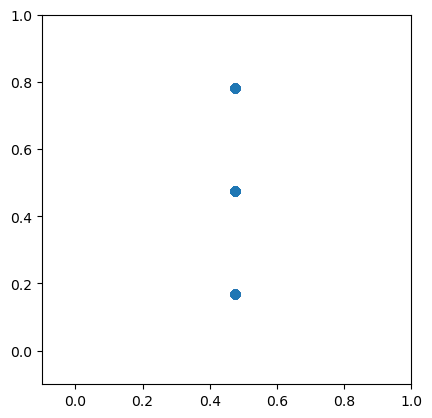

In [19]:
animate_HK_2D_simulation(res_arr, f"{round_nei.__name__}.gif")